### Для стандартных задачь в DL уже есть готовые решения и библиотеки, которые значительно ускоряют решение задачи и позволяют быстро построить базовое решение с хорошим результатом.
![](https://www.meme-arsenal.com/memes/0eb7d7ba093f7a61409127282e0d4f1b.jpg)

Немного погуглив и поспрашивая коллег я нашел множество решений под нашу задачу с уже предобучеными моделями со своими обертками и готовыми пеплайнами.
Например:

* [https://finetune.indico.io](https://finetune.indico.io)
* [https://github.com/huggingface/pytorch-transformers](https://github.com/huggingface/pytorch-transformers)
* [https://github.com/deepset-ai/FARM](https://github.com/deepset-ai/FARM)
* [https://github.com/kaushaltrivedi/fast-bert](https://github.com/kaushaltrivedi/fast-bert)
* [https://github.com/amaiya/ktrain](https://github.com/amaiya/ktrain)

С последней и поработаем. Посмотрим что получилось...



In [1]:
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: keras-preprocessing, h5py, keras-applications, six, pyyaml, scipy, numpy
Required-by: keras-tqdm, ethnicolr


In [2]:
!pip install ktrain

     |████████████████████████████████| 81kB 3.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.3.1-cp36-none-any.whl size=91990 sha256=4dffcf6cfc59ce53d9d62dadfb16b94a0fced7cc198ca55192995c894c4cdbfc
  Stored in directory: /tmp/.cache/pip/wheels/13/e4/12/8d49543cb022e7928fb86388d5ab0b2163ce04f5e094362a1b
  Created wheel for keras-bert: filename=keras_bert-0.78.0-cp36-none-any.whl size=37882 sha256=e960a7607845e446bdfeb2da74c5204a7f589e0efa7dff7b6a8cf5e170633cf5
  Stored in directory: /tmp/.cache/pip/wheels/9f/2a/a3/a4741e16520a3d651bf895e5fba34d886a993efdbb303ffc11
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=7072777648309d7b964e5df656cac8b21b7463ad3797832d759ccfddd24d7c69
  Stored in directory: /tmp/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for keras-transformer: filename=keras_transformer-0.30.0-cp36-none-any.whl size=13388 sha256=7ec39d6e219a3f6b627351e76760d9f67f34c2cdc47e6525147bb90

In [3]:
!pip freeze > requirements.txt

In [4]:
import ktrain
from ktrain import text

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dl-movie-genre-classification/sample-submission.csv
/kaggle/input/sf-dl-movie-genre-classification/train.csv
/kaggle/input/sf-dl-movie-genre-classification/test.csv


# SETUP
В setup выносим основные настройки

In [6]:
# MODEL
#BATCH_SIZE  = 32
EPOCH       = 3
VAL_SPLIT   = 0.10  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAXLEN    = 200

DATA_PATH = '/kaggle/input/sf-dl-movie-genre-classification/'
PATH      = '/kaggle/working/'

# Data
#### TRAIN

In [7]:
train = pd.read_csv(DATA_PATH+'train.csv',)

In [8]:
train.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
name     54214 non-null object
genre    54214 non-null object
text     54214 non-null object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

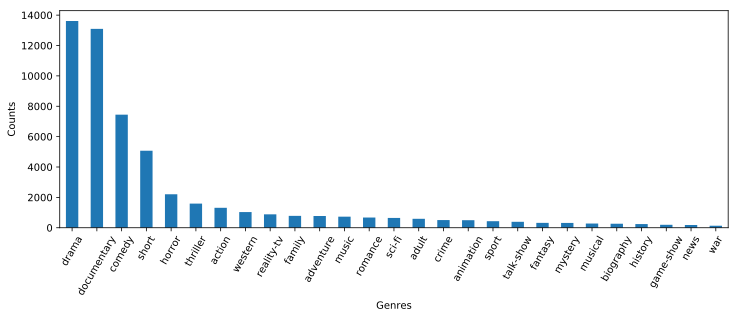

In [10]:
train.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [11]:
test = pd.read_csv(DATA_PATH+'test.csv',)
test.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


# Data preprocessing

In [12]:
# Подготовим таргеты
classes =  list(set(train.genre))
#Y = pd.get_dummies(train.genre)
#classes =  Y.columns
train = train[['text', 'genre']]
train = pd.get_dummies(train, prefix='', prefix_sep='', columns=['genre',])
train.to_csv('train_df.csv', index=False)
train.head(3)

,text,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Listening in to a conversation between his do...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,A brother and sister with a past incestuous r...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,As the bus empties the students for their fie...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# MODEL ktrain power
Далее Основываясь на примерах:
* [https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb](https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb)
* и исходниках

строим свое решение

In [13]:
text.print_text_classifiers()

fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
bigru: Bidirectional GRU with pretrained word vectors (https://arxiv.org/abs/1712.09405)
bert: Bidirectional Encoder Representations from Transformers (https://arxiv.org/abs/1810.04805)


В ktrain доступно множество готовых решений под классификацию текста.  
Берем BERT тк сейчас эта одна из лучших языковых моделей: [https://habr.com/ru/post/436878/](https://habr.com/ru/post/436878/)
![](http://www.aitimes.kr/news/photo/201901/13117_13465_1541.jpg)

In [14]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train, 
                                                                   text_column='text',
                                                                   label_columns=classes,
                                                                   val_pct=VAL_SPLIT, 
                                                                   max_features=MAX_WORDS, 
                                                                   maxlen=MAXLEN,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

downloading pretrained BERT model and vocabulary...
[██████████████████████████████████████████████████]
extracting pretrained BERT model and vocabulary...
done.

cleanup downloaded zip...
done.

preprocessing train...


preprocessing test...


In [15]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, )

Is Multi-Label? False
maxlen is 200
done.


In [16]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

In [17]:
learner.autofit(1e-5, EPOCH)



begin training using triangular learning rate policy with max lr of 1e-05...
Train on 48792 samples, validate on 5422 samples
Epoch 1/3
48792/48792 [==============================] - 1202s 25ms/step - loss: 1.6018 - acc: 0.5416 - val_loss: 1.1782 - val_acc: 0.6546
Epoch 2/3
48792/48792 [==============================] - 1188s 24ms/step - loss: 1.0916 - acc: 0.6713 - val_loss: 1.1129 - val_acc: 0.6619
Epoch 3/3
48792/48792 [==============================] - 1188s 24ms/step - loss: 0.9543 - acc: 0.7086 - val_loss: 1.1020 - val_acc: 0.6630


In [18]:
learner.save_model('model_1')

# Submission

In [19]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('predictor_1')

In [20]:
predict = predictor.predict(test.text.values)

In [21]:
submission = pd.DataFrame({'id':range(1, len(predict)+1),'genre':predict},columns=['id', 'genre'])
submission.to_csv('submission.csv', index=False)
submission.head()

,id,genre
0,1,thriller
1,2,drama
2,3,documentary
3,4,drama
4,5,drama


In [22]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = predictor.predict_proba(test.text.values)
predict_proba = pd.DataFrame(predict_proba, columns=classes)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

,comedy,musical,reality-tv,fantasy,thriller,mystery,romance,sport,crime,action,...,music,biography,history,drama,sci-fi,talk-show,game-show,animation,adventure,horror
0,0.013971,0.000808,0.000570,0.006358,0.452686,0.035048,0.001911,0.000204,0.017291,0.003975,...,0.000726,0.000947,0.000705,0.117297,0.014381,0.000407,0.000254,0.002262,0.002078,0.230883
1,0.370603,0.001732,0.000542,0.000922,0.000990,0.000517,0.001395,0.000660,0.001530,0.001361,...,0.000274,0.002268,0.001462,0.559804,0.000229,0.000052,0.000117,0.005422,0.001511,0.001047
2,0.000176,0.000081,0.000580,0.000048,0.000076,0.000072,0.000031,0.000158,0.000056,0.000080,...,0.000186,0.002583,0.001663,0.003544,0.000114,0.000054,0.000046,0.000190,0.000117,0.000018
3,0.044462,0.005421,0.002449,0.001502,0.004242,0.000763,0.009870,0.000442,0.000489,0.003714,...,0.001193,0.001601,0.000636,0.866642,0.000976,0.000158,0.000221,0.001170,0.001853,0.000315
4,0.026194,0.001751,0.000204,0.000843,0.004056,0.000935,0.013028,0.000524,0.003384,0.027583,...,0.000262,0.000983,0.000906,0.903197,0.000398,0.000076,0.000114,0.000706,0.001576,0.000919


# Итого:
### Вот так С минимальным кодом имеем лучшее решение! 


![](https://memchik.ru/images/mems/5c3d8f1ee1915.jpg)

# Что можно сделать, чтоб улучшить результат:
* Подобрать другие переменные
* Подобрать политику обучения (в либе множество вариантов уже [готовы](https://github.com/amaiya/ktrain/blob/4c9462539fef682572db89d3a2fbaaf2549d2978/tutorial-02-tuning-learning-rates.ipynb))
* Добавить в обучение название фильма
* Попробовать другие модели